In [1]:
using RData, LightGraphs, Colors, Missings, DataFrames, Gadfly, Plots, CSV, Compose, PyPlot
include("code/BGSM_effective_resistance.jl");
include("code/model_selection.jl");

INFO: Recompiling stale cache file /Users/yosikim/.julia/lib/v0.6/LightGraphs.ji for module LightGraphs.


In [2]:
finaldata = CSV.read("data/chicagocrime.txt", delim = ' ');

In [ ]:
# data preprocessing
# DO NOT RUN, this is just to show how the data is preprocessed

data = CSV.read("/Users/yosikim/Downloads/chicagocrime.csv", delim = ',');
data1 = data[:,[3;12;14;16;17;18;20;21]]; names(data1)[3] = "Community_Area";
data1[:Month] = 0;
for i = 1:size(data1,1)
    data1[:Month][i] = (Int(data1[:Date][i][1]) - 48) * 10 + Int(data1[:Date][i][2]) - 48
end
nonnull = find((ismissing.(data1[:Month]) .== false) .& (ismissing.(data1[:Year]) .== false)
                .& (ismissing.(data1[:Community_Area]) .== false) .& (ismissing.(data1[:District]) .== false)
                .& (ismissing.(data1[:Latitude]) .== false) .& (ismissing.(data1[:Longitude]) .== false)
               );
data2 = data1[nonnull,:];
community = Array{Int}(data2[:Community_Area]);
district = Array{Int}(data2[:District]);
disappeared_district = find((data2[:District] .!= 13) .& (data2[:District] .!= 21)
                       .& (data2[:District] .!= 23) .& (data2[:District] .!= 31));
data3 = data2[disappeared_district,:];
finalind = find((data3[:X_Coordinate] .> 0) .& (data3[:Y_Coordinate] .> 0));
finaldata = data3[finalind,:];

In [3]:
# see how data look like
finaldata[:Season] = finaldata[:Year] + floor.(finaldata[:Month]/3)/4;
finaldata = finaldata[find(finaldata[:Community_Area] .> 0),:]
head(finaldata)

6×10 DataFrames.DataFrame. Omitted printing of 6 columns
│ Row │ Date                   │ District │ Community_Area │ X_Coordinate │
├─────┼────────────────────────┼──────────┼────────────────┼──────────────┤
│ 1   │ 03/18/2015 07:44:00 PM │ 11       │ 25             │ 1144606      │
│ 2   │ 03/18/2015 11:00:00 PM │ 7        │ 67             │ 1166468      │
│ 3   │ 03/18/2015 10:45:00 PM │ 2        │ 39             │ 1185075      │
│ 4   │ 03/18/2015 10:30:00 PM │ 2        │ 40             │ 1178033      │
│ 5   │ 03/18/2015 09:00:00 PM │ 11       │ 25             │ 1144920      │
│ 6   │ 03/18/2015 10:00:00 PM │ 2        │ 39             │ 1183018      │

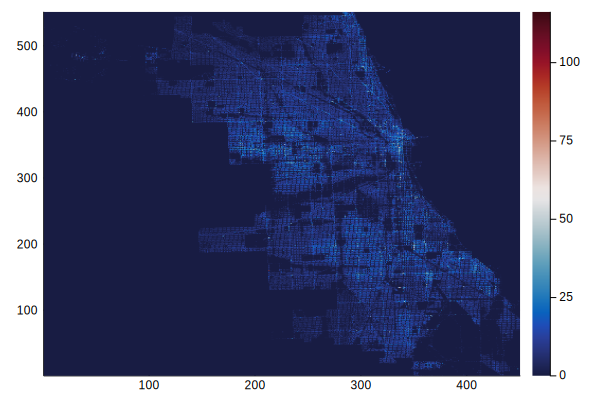

In [4]:
## discretization of the chicago crime data

lati = floor.(Int,finaldata[:Y_Coordinate]/10^3 * 4 + 0.5); lati = lati - minimum(lati) + 1;
long = floor.(Int,finaldata[:X_Coordinate]/10^3 * 4 + 0.5); long = long - minimum(long) + 1;
n1 = maximum(lati); n2 = maximum(long);
z = zeros(n1*n2); w = zeros(n1*n2); v = zeros(n1,n2);
for i = 1:length(lati)
    ind = (lati[i] - 1) * n2 + long[i];
    z[ind] += 1;
    w[ind] = finaldata[:District][i];
    v[ind] = finaldata[:Community_Area][i];
end
Z = reshape(z,n2,n1)';
W = reshape(w,n2,n1)';
V = reshape(v,n2,n1)';
Y = sqrt.(Z);
default(dpi = 400)
heatmap(Y, fillcolor = :balance)

In [5]:
## combine data by district

district_name = ["1st District – Central";
"2nd District – Wentworth";
"3rd District – Grand Crossing";
"4th District – South Chicago";
"5th District – Calumet";
"6th District – Gresham";
"7th District – Englewood";
"8th District – Chicago Lawn";
"9th District – Deering";
"10th District – Ogden";
"11th District – Harrison";
"12th District – Near West";
"14th District – Shakespeare";
"15th District – Austin";
"16th District – Jefferson Park";
"17th District – Albany Park";
"18th District – Near North";
"19th District – Town Hall";
"20th District – Lincoln";
"22nd District – Morgan Park";
"24th District – Rogers Park";
"25th District – Grand Central";];

year = sort(unique(finaldata[:Season]))
district_enumerate = sort(unique(finaldata[:District]));
district_mean = zeros(length(district_name),length(year));
district_sum = zeros(length(district_name),length(year));
district_num = zeros(length(district_name));

for i = 1:length(district_name)
    district_num[i] = sum(W .== district_enumerate[i]);
    ind = findin(finaldata[:District], district_enumerate[i]);
    for j = 1:length(year)
        district_sum[i,j] = sum(finaldata[:Season][ind] .== year[j]);
        district_mean[i,j] = district_sum[i,j]/district_num[i];
    end
end

In [6]:
## combine data by community area

community_name = 1:77;

community_enumerate = sort(unique(finaldata[:Community_Area]));
community_num = zeros(length(community_name));
community_pop = [54991;71942;56362;39493;31867;94368;64116;80484;11187;37023;
                25448;18508;17931;51542;64124;53359;41932;13426;78743;25010;
                39262;73595;56323;81432;98514;18001;20567;54881;35912;79288;
                35769;29283;21390;13391;18238;5918;2876;21929;17841;11717;
                25681;25983;49767;31028;10185;31198;2916;13812;44619;7325;
                15109;23042;29651;6482;9426;34513;13393;45368;15612;31977;
                44377;18109;39894;23139;33355;55628;35505;30654;32602;41081;
                48743;20034;26493;19093;22544;12756;56521]

for i = 1:length(community_name)
    community_num[i] = sum(V .== community_enumerate[i]);
end

community_dens = community_pop ./ community_num;

In [7]:
## calculate district population

district_pop = zeros(22);

for i = 1:22
    for j = 1:77
        district_pop[i] += sum((W .== district_enumerate[i]) .& (V .== j)) * community_dens[j]
    end
end
district_pop = district_pop/1e5;

district_mean0 = copy(district_mean);
district_sum0  = copy(district_sum);
district_mean  = district_mean ./ district_pop;
district_sum   = district_sum ./ district_pop;

In [8]:
# make data frame for plotting

y = reshape(sum(reshape(district_mean[:,3:70]',4,17*22),1)[:],17,22)';
df2 = DataFrame(y = y[:],
    m = (y ./ mean(y,1) * mean(y))[:],
    district = repeat(district_name, outer = 17),
    year = repeat(2002:2018, inner = 22));

df = DataFrame(y = district_sum[:],
    m = district_mean[:],
    district = repeat(district_name, outer = length(year)),
    year = repeat(year, inner = length(district_name)));
ind = find((df[:year] .>= 2003) .& (df[:year] .<= 2017.75))
df1 = df[ind,:];
x = 2003:0.25:2017.75;
y = mean(district_mean[:,9:end-3],1)[:];
beta = (y - mean(y))'*(x - mean(x))/norm(x - mean(x))^2;
correct = beta * x + mean(y) - beta * mean(x);
df1[:c] = df1[:m] - repeat(correct, inner = 22)[:];
yearlymean = mean(reshape(district_sum[:,9:68],88,15),1)[:];
df1[:r] = df1[:m] ./ repeat(yearlymean, inner = 88) * sum(yearlymean);

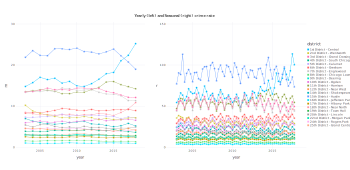

In [9]:
set_default_plot_size(35cm, 17cm)
F1 = Gadfly.plot(df2[23:end,:], x = :year, y = :m, color = :district, Geom.line, Geom.point,
    Theme(key_position = :none), Coord.Cartesian(xmin = 2002, xmax = 2019))
F2 = Gadfly.plot(df1, x = :year, y = :r, color = :district, Geom.line, Geom.point,
Coord.Cartesian(xmin = 2002, xmax = 2019))
F = title(hstack(
    compose(context(0, 0, 15cm, 15cm), render(F1)), compose(context(0, 0cm, 20cm, 15cm), render(F2))),
    "Yearly (left) and Seasonal (right) crime rate")
Gadfly.draw(PDF("F15.pdf"), F);
CSV.write("result/chicagocrime1.txt", df1, delim = ',');
CSV.write("result/chicagocrime2.txt", df2, delim = ',');
F

In [10]:
g = Graph(22);
add_edge!(g,(1,2)); add_edge!(g,(1,9)); add_edge!(g,(1,12)); add_edge!(g,(1,17));
add_edge!(g,(2,3)); add_edge!(g,(2,6)); add_edge!(g,(2,7)); add_edge!(g,(2,9));
add_edge!(g,(3,4)); add_edge!(g,(3,6)); add_edge!(g,(3,7));
add_edge!(g,(4,5)); add_edge!(g,(4,6));
add_edge!(g,(5,6));
add_edge!(g,(6,7)); add_edge!(g,(6,8)); add_edge!(g,(6,20));
add_edge!(g,(7,8)); add_edge!(g,(7,9));
add_edge!(g,(8,9)); add_edge!(g,(8,10));
add_edge!(g,(9,10)); add_edge!(g,(9,12));
add_edge!(g,(10,11)); add_edge!(g,(10,12));
add_edge!(g,(11,12)); add_edge!(g,(11,13)); add_edge!(g,(11,14)); add_edge!(g,(11,22));
add_edge!(g,(12,17)); #add_edge!(g,(12,13));
add_edge!(g,(13,18)); add_edge!(g,(13,16)); add_edge!(g,(13,17)); add_edge!(g,(13,22));
add_edge!(g,(14,22));
add_edge!(g,(15,16)); add_edge!(g,(15,22));
add_edge!(g,(16,18)); add_edge!(g,(16,19)); add_edge!(g,(16,21));
add_edge!(g,(17,18));
add_edge!(g,(18,19));
add_edge!(g,(19,21));
h = PathGraph(17);
G = cartesian_product(h, g);

In [11]:
# fit the best model

D = -full(incidence_matrix(G, oriented = true))';
R = effective_resistance(G,D);
y = log.(df2[:m] + 1);
y = df2[:m];
out = BGSM_effective_resistance(y, D, R, v0 = 1e-3 * 8, v1 = 1e4, b = 22, verbose = false);
out_ms = model_selection(out);
df2[:fit] = out_ms[:t_full];
println(out_ms[:score])

1087.1718421870562


In [12]:
temp = round.(Int,reshape(df2[:fit], 22, 17));
B1 = copy(W);
for i = 1:22
    B1[find(W .== district_enumerate[i])] = findin(sort(unique(temp[:,8])), temp[i,8])[1]
end
B2 = copy(W);
for i = 1:22
    B2[find(W .== district_enumerate[i])] = findin(sort(unique(temp[:,15])), temp[i,15])[1]
end
B3 = copy(W);
for i = 1:22
    B3[find(W .== district_enumerate[i])] = findin(sort(unique(temp[:,17])), temp[i,17])[1]
end
B1[B1 .== 0] = NaN;
B2[B2 .== 0] = NaN;
B3[B3 .== 0] = NaN;
F11 = heatmap(B1, fillcolor = :balance, clim = (0,length(sort(unique(temp[:,8])))),
    legend = :none, title = "Year of 2011");
F12 = heatmap(B2, fillcolor = :balance, clim = (0,length(sort(unique(temp[:,15])))),
    legend = :none, title = "Year of 2014");
F13 = heatmap(B3, fillcolor = :balance, clim = (0,length(sort(unique(temp[:,17])))),
    title = "Year of 2017");
F4 = Plots.plot(F11,F12,F13, size = (1800,450), layout = grid(1,3,widths=[0.3,0.3,0.41]), axis = false)
savefig("figure/fig_chicago3.pdf");

In [13]:
df3 = DataFrame(A = B1[:], B = B2[:], C = B3[:]);
CSV.write("result/chicagocrime3.txt", df3, delim = ',');

In [14]:
function BGSM_cartesian(y, D1, D2, R1, R2;
                        init = y, v0 = 1e-1, v1 = 1e6,
                        c = 0.1, convtol = 1e-14,  
                        iter = 100)
                            
    
    # get size
    n1,n2 = size(y); n1 = Int(n1/4); n = n1 * n2;
    
    # initialize
    theta = copy(y);
    q1 = zeros(size(D1,1)); q2 = zeros(size(D2,1));
    sigmasq1 = 1; sigmasq2 = c;
    m = mean(y);
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1
        d1 = sum((D1*theta[1:22,:]).^2 + (D1*theta[23:44,:]).^2 + (D1*theta[45:66,:]).^2 +
                (D1*theta[67:88,:]).^2,2);

        q1 = 1./( 1 + sqrt(v0/v1).^R1 .* exp.(d1/2 * (1/v0 - 1/v1)/sigmasq1) );
        
        # E-step: update g2
        d2 = sum((D2*theta').^2,2);
        q2 = 1./( 1 + sqrt(v0/v1).^R2 .* exp.(d2/2 * (1/v0 - 1/v1)/sigmasq2) );
        
        # M-step: update theta
        L1 = D1' * Diagonal(q1[:]) * D1/v0;
        L2 = D2' * Diagonal(q2[:]) * D2/v0;
        L = kron(L2, speye(22)) + kron(speye(15),L1);
        
        theta = [reshape((speye(n) + L)\y[1:22,:][:], 22,15);
                reshape((speye(n) + L)\y[23:44,:][:], 22,15);
                reshape((speye(n) + L)\y[45:66,:][:], 22,15);
                reshape((speye(n) + L)\y[67:88,:][:], 22,15)];
        
        
        if (norm(q1 - q1_old) + norm(q2 - q2_old) < convtol)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2)
                ])
end

BGSM_cartesian (generic function with 1 method)

In [15]:
D1 = -full(incidence_matrix(g, oriented = true))';
A1 = full(adjacency_matrix(g));
h  = PathGraph(15);
D2 = -full(incidence_matrix(h, oriented = true))';
A2 = full(adjacency_matrix(h));
A  = kron(speye(15),A1) + kron(A2,speye(22));
G  = Graph(A)
D  = -incidence_matrix(G, oriented = true)';
DD = [kron(speye(15),D1);kron(D2,speye(22))];
R  = effective_resistance(G,DD);
R1 = sum(reshape(R[1:43*15],43,15),2)[:];
R2 = sum(reshape(R[43*15+1:end],22,14),1)[:];

In [16]:
out2 = BGSM_cartesian(reshape(df1[:r],88,15)/100, D1, D2, R1, R2, v0 = 1e-3 * 5, c = 0.1, iter = 200);
ind1 = find(out2[:q1] .> 0.5)

# get a thresholded graph
L1 = D1[ind1,:]'*D1[ind1,:];
g1 = Graph((abs.(L1) - L1)/2);
    
# edge contraction / node merger
c1 = connected_components(g1);

ind2 = find(out2[:q2] .> 0.5);
    
# get a thresholded graph
L2 = D2[ind2,:]'*D2[ind2,:];
g2 = Graph((abs.(L2) - L2)/2);
    
# edge contraction / node merger
c2 = connected_components(g2);

df1[:Year] = floor.(df1[:year])
df1[:Season] = ["Winter";"Spring";"Summer";"Fall"][Array{Int}(4 * (df1[:year] - df1[:Year])) + 1];
df1[:fit] = (out2[:theta])[:] * 100;
df1[:Year] = floor.(df1[:year])
df1[:Season] = ["Winter";"Spring";"Summer";"Fall"][Array{Int}(4 * (df1[:year] - df1[:Year])) + 1];
df1[:group] = repeat(["Central(1st)";"Far South(2nd,5th,6th)";"Southwest(3rd,7th)";
"Far Southeast(4th)"; "Far South(2nd,5th,6th)";"Far South(2nd,5th,6th)";"Southwest(3rd,7th)";
"West(8th,9th,10th,12th)";"West(8th,9th,10th,12th)";"West(8th,9th,10th,12th)";
"Harrison(11th)";"West(8th,9th,10th,12th)";"Shakespeare(14th)";
"Austin(15th)"; "North(16th,17th,19th,20th,24th,25th)";"North(16th,17th,19th,20th,24th,25th)";
"Near North(18th)";"North(16th,17th,19th,20th,24th,25th)"; "North(16th,17th,19th,20th,24th,25th)";
"Far Southwest(22nd)";"North(16th,17th,19th,20th,24th,25th)";"North(16th,17th,19th,20th,24th,25th)"],outer = 60);

In [17]:
F6 = Gadfly.plot(df1, x = :year, y = :fit, color = :group, shape = :Season,
    size = repeat([3pt;4pt;4pt;4pt], inner = 22),
    Geom.line, Geom.point,
    Coord.Cartesian(xmin = 2002.5, xmax = 2018),
    Scale.color_discrete_manual(RGB(cgrad(:balance)[26]), RGB(cgrad(:balance)[15]), RGB(cgrad(:balance)[21]),
    RGB(cgrad(:balance)[9]), RGB(cgrad(:balance)[6]), RGB(cgrad(:balance)[24]),
    RGB(cgrad(:balance)[12]), RGB(cgrad(:balance)[29]), RGB(cgrad(:balance)[4]),
    RGB(cgrad(:balance)[18]), RGB(cgrad(:balance)[1])),
    Guide.title("The estimated seasonal trend of Chicago crime rate"))
Gadfly.draw(PDF("F16.pdf"), F6);

In [24]:
F11 = heatmap(B2, fillcolor = :balance, clim = (0,length(sort(unique(temp[:,13])))),
    legend = :none, title = "Yearly data", ticks = false, axis = false);
F22 = heatmap(B1, fillcolor = :balance, clim = (0,length(sort(unique(temp[:,end-8])))),
    legend = :none, ticks = false, axis = false);
savefig("figure/F22.pdf")

In [25]:
xloc = zeros(22); yloc = zeros(22);
for i = 1:22
    yloc[i] = mean(rem.(find(W .== district_enumerate[i]) - 1, 551) + 1)
    xloc[i] = mean(ceil.(Int, find(W .== district_enumerate[i]) / 551))
end

A = incidence_matrix(g); xedge = zeros(43,2); yedge = zeros(43,2);
for i = 1:43
    xedge[i,:] = [xloc[find(A[:,i])[1]];xloc[find(A[:,i])[2]]]
    yedge[i,:] = [yloc[find(A[:,i])[1]];yloc[find(A[:,i])[2]]]
end

In [26]:
t = round.(Int, reshape(df1[:fit], 22, 60));
figure(figsize=(10,6))
cols = repeat([cgrad(:balance)[1]],22);
index = [4;8;12;56;60]
for j = 1:5
    
    if (j != 2) & (j != 3)
        ind = index[j];
        a = maximum(t[:,ind]);
        for i = 1:22
            cols[i] = cgrad(:balance)[min(t[i,ind]/a,1)]
        end
        pcols = map(col -> (red(col), green(col), blue(col)), cols);
        PyPlot.scatter3D(yloc + j * 20, xloc + j * 50, j * 2, alpha = 1, c = pcols, s = 10)
        PyPlot.plot(yedge' + j * 20, xedge' + j * 50, j * 2, color = :black, linewidth = 0.1)
        PyPlot.scatter3D(yloc + j * 20, xloc + j * 50, j * 2, alpha = 1, c = pcols, s = 10)
    end
end
for i = 1:22
    cols[i] = cgrad(:balance)[min(temp1[i,1 * 15]/a,1)]
end
pcols = map(col -> (red(col), green(col), blue(col)), cols);
PyPlot.scatter3D(yloc + 1 * 20, xloc + 1 * 50, 1 * 2, alpha = 1, c = pcols, s = 10)
PyPlot.scatter3D(170,620,1.2, s = 2, color = :black);
PyPlot.scatter3D(200,600,2.2, s = 2, color = :black);
PyPlot.scatter3D(230,580,3.2, s = 2, color = :black)
axis("off");
PyPlot.savefig("figure/F23.pdf");

LoadError: [91mUndefVarError: figure not defined[39m

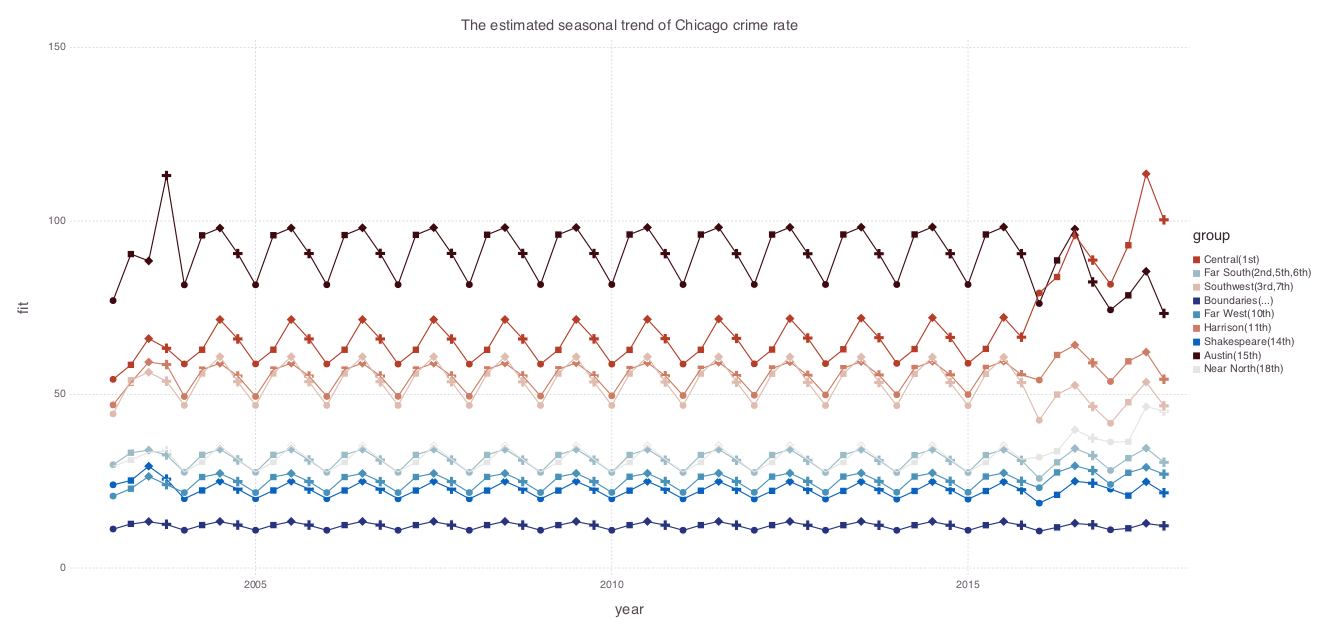

In [266]:
gg = copy(g);
add_edge!(gg,(4,8)); add_edge!(gg,(8,20)); add_edge!(gg,(20,21)); add_edge!(gg,(21,4));
D1 = -full(incidence_matrix(gg, oriented = true))';
A1 = full(adjacency_matrix(gg));
h  = PathGraph(15);
D2 = -full(incidence_matrix(h, oriented = true))';
A2 = full(adjacency_matrix(h));
A  = kron(speye(15),A1) + kron(A2,speye(22));
G  = Graph(A)
D  = -incidence_matrix(G, oriented = true)';
DD = [kron(speye(15),D1);kron(D2,speye(22))];
R  = effective_resistance(G,DD);
R1 = sum(reshape(R[1:47*15],47,15),2)[:];
R2 = sum(reshape(R[47*15+1:end],22,14),1)[:];
out2 = BGSM_cartesian(reshape(df1[:r],88,15)/100, D1, D2, R1, R2, v0 = 1e-3 * 4.5, c = 0.1, iter = 200);
ind1 = find(out2[:q1] .> 0.5)

# get a thresholded graph
L1 = D1[ind1,:]'*D1[ind1,:];
g1 = Graph((abs.(L1) - L1)/2);
    
# edge contraction / node merger
c1 = connected_components(g1);

ind2 = find(out2[:q2] .> 0.5);
    
# get a thresholded graph
L2 = D2[ind2,:]'*D2[ind2,:];
g2 = Graph((abs.(L2) - L2)/2);
    
# edge contraction / node merger
c2 = connected_components(g2);

df1[:Year] = floor.(df1[:year])
df1[:Season] = ["Winter";"Spring";"Summer";"Fall"][Array{Int}(4 * (df1[:year] - df1[:Year])) + 1];
df1[:fit] = (out2[:theta])[:] * 100;
df1[:Year] = floor.(df1[:year])
df1[:Season] = ["Winter";"Spring";"Summer";"Fall"][Array{Int}(4 * (df1[:year] - df1[:Year])) + 1];
df1[:group] = repeat(["Central(1st)";"Far South(2nd,5th,6th)";"Southwest(3rd,7th)";
"Boundaries(...)"; "Far South(2nd,5th,6th)";"Far South(2nd,5th,6th)";"Southwest(3rd,7th)";
"Boundaries(...)";"Boundaries(...)";"Far West(10th)";
"Harrison(11th)";"Boundaries(...)";"Shakespeare(14th)";
"Austin(15th)"; "Boundaries(...)";"Boundaries(...)";
"Near North(18th)";"Boundaries(...)"; "Boundaries(...)";
"Boundaries(...)";"Boundaries(...)";"Boundaries(...)"],outer = 60);
F7 = Gadfly.plot(df1, x = :year, y = :fit, color = :group, shape = :Season,
    size = repeat([3pt;4pt;4pt;4pt], inner = 22),
    Geom.line, Geom.point,
    Coord.Cartesian(xmin = 2002.5, xmax = 2018),
    Scale.color_discrete_manual(RGB(cgrad(:balance)[24]),RGB(cgrad(:balance)[12]),RGB(cgrad(:balance)[18]),
                                RGB(cgrad(:balance)[3]),RGB(cgrad(:balance)[9]),RGB(cgrad(:balance)[21]),
                                RGB(cgrad(:balance)[6]),RGB(cgrad(:balance)[30]), RGB(cgrad(:balance)[15])),
    Guide.title("The estimated seasonal trend of Chicago crime rate"))
Gadfly.draw(PDF("F16.pdf"), F7);
F7

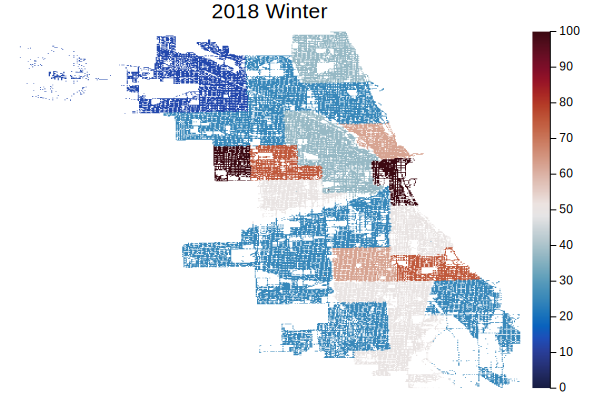

In [28]:
out = BGSM_effective_resistance(reshape(df1[:m],22,60)[:,60], D1, R1, v0 = 1e-4 * 1, verbose = false)
ms = model_selection(out);
A1 = copy(W);
b = round.(ms[:beta] * 2 + 1) * 12.5;
for i = 1:22
    A1[find(W .== district_enumerate[i])] = b[i]
end
a = length(unique(b));
A1[A1 .== 0] = NaN;
F111 = heatmap(A1, fillcolor = :balance, clim = (0,100), title = "2018 Winter"
    , ticks = false, axis = false)

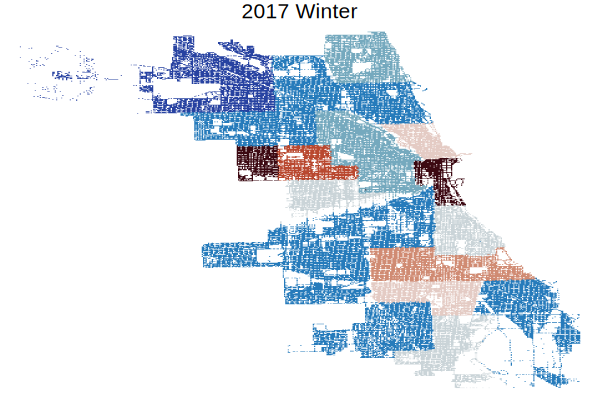

In [1050]:
out = BGSM_effective_resistance(reshape(df1[:m],22,60)[:,56], D1, R1, v0 = 1e-4 * 5, verbose = false)
ms = model_selection(out);
A1 = copy(W);
b = round.(ms[:beta] * 2 + 1);
for i = 1:22
    A1[find(W .== district_enumerate[i])] = b[i]
end
a = length(unique(b));
A1[A1 .== 0] = NaN;
F112 = heatmap(A1, fillcolor = :balance, clim = (0,a), title = "2017 Winter"
    , legend = :none, ticks = false, axis = false)

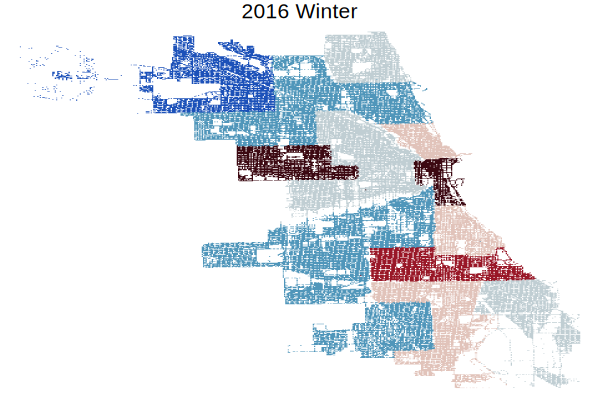

In [1051]:
out = BGSM_effective_resistance(reshape(df1[:m],22,60)[:,52], D1, R1, v0 = 1e-4 * 2, verbose = false)
ms = model_selection(out);
A1 = copy(W);
b = round.(ms[:beta] * 2 + 1);
for i = 1:22
    A1[find(W .== district_enumerate[i])] = b[i]
end
a = length(unique(b));
A1[A1 .== 0] = NaN;
F113 = heatmap(A1, fillcolor = :balance, clim = (0,a), title = "2016 Winter"
    ,legend = :none, ticks = false, axis = false)

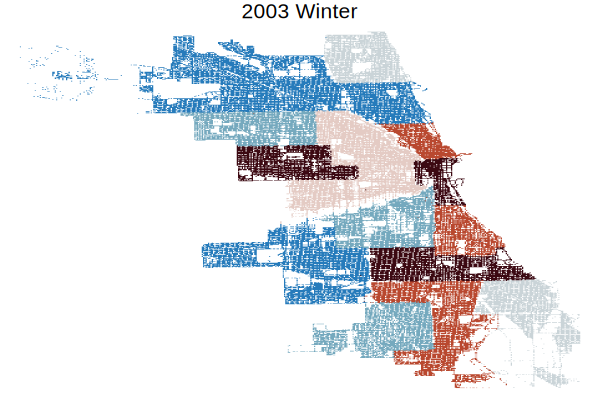

In [1052]:
out = BGSM_effective_resistance(reshape(df1[:m],22,60)[:,4], D1, R1, v0 = 1e-4 * 5, verbose = false)
ms = model_selection(out);
A1 = copy(W);
b = round.(ms[:beta] * 2 + 1);
for i = 1:22
    A1[find(W .== district_enumerate[i])] = b[i]
end
a = length(unique(b));
A1[A1 .== 0] = NaN;
F114 = heatmap(A1, fillcolor = :balance, clim = (0,a), title = "2003 Winter"
    ,legend = :none, ticks = false, axis = false)

In [1055]:
F115 = Plots.plot(F114,F113,F112,F111, 
    size = (2400,500), 
    layout = grid(1,4,widths=[0.23,0.23,0.23,0.31]), axis = false)
savefig("figure/F24.pdf")

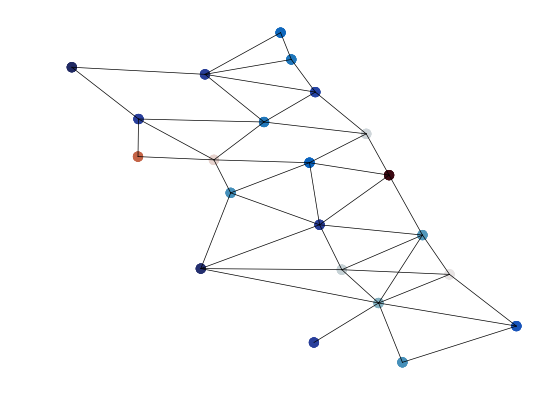

In [1082]:
t = reshape(df1[:m],22,60)[:,60];
for i = 1:22
    cols[i] = cgrad(:balance)[t[i]/maximum(t)]
end
pcols = map(col -> (red(col), green(col), blue(col)), cols);
        PyPlot.scatter(xloc, yloc, alpha = 1, c = pcols, s = 20)
        PyPlot.plot(xedge', yedge', color = :black, linewidth = .5)
PyPlot.scatter(xloc, yloc, alpha = 1, c = pcols, s = 40)
PyPlot.scatter(xloc, yloc, alpha = 1, c = pcols, s = 40)
PyPlot.scatter(xloc, yloc, alpha = 1, c = pcols, s = 40)
PyPlot.scatter(xloc, yloc, alpha = 1, c = pcols, s = 40)
axis("off");
PyPlot.savefig("figure/F25.pdf")